In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Load the preprocessed data

In [3]:
# Load DataFrame from the pickle file
features = pd.read_pickle('features.pkl')
target = pd.read_pickle('target_classification.pkl')

# Split the data to train and test sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 123, stratify = target)

In [5]:
print(X_train.shape)
print(X_test.shape)

(1913, 12)
(479, 12)


# BNN

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchbnn as bnn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tqdm import tqdm

In [6]:
# Tensors for the BNN
X_train_tens = torch.tensor(X_train.values)
y_train_tens = torch.tensor(y_train.values)
X_test_tens = torch.tensor(X_test.values)
y_test_tens = torch.tensor(y_test.values)

In [7]:
num_of_train_data = X_train_tens.shape[0]
print(f"Number of training samples: {num_of_train_data}")

num_of_test_data = X_test_tens.shape[0]
print(f"Number of test samples: {num_of_test_data}")

num_of_classes = np.unique(y_train).size
print(f"Number of classes: {num_of_classes}")

num_of_inputs = X_train_tens.shape[1]
print(f"Number of inputs: {num_of_inputs}")

Number of training samples: 1913
Number of test samples: 479
Number of classes: 5
Number of inputs: 12


In [8]:
# Training data to a right form for the model
train_dataset = TensorDataset(X_train_tens, y_train_tens)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=False)

In [9]:
# Model
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.3, in_features=num_of_inputs, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=num_of_classes, bias=True)
)

## Training

In [10]:
# Class weights for ce_loss-function
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Initializations
ce_loss = nn.CrossEntropyLoss(weight=class_weights)
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.1
optimizer = optim.Adam(model.parameters(), lr=0.008) 
scheduler = ExponentialLR(optimizer, gamma=0.99)

# Number of training epochs
num_epochs = 200
# Model to the train mode
model.train()  

ce_losses = []
kl_losses = []
epochs = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    ce_total = 0.0
    kl_total = 0.0
    total_batches = 0
    
    for inputs, labels in train_loader: # One batch at a time
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.long)
        
        # Loss
        pre = model(inputs)
        ce = ce_loss(pre, labels)
        kl = kl_loss(model)
        cost = ce + kl_weight * kl
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        ce_total += ce.item()
        kl_total += kl.item()
        total_batches += 1
    
    # Mean loss per batch
    avg_ce = ce_total / total_batches
    avg_kl = kl_total / total_batches

    ce_losses.append(avg_ce)
    kl_losses.append(kl_weight * avg_kl)
    epochs.append(epoch + 1) 

    # # Use this if you want to stop the decreasing of the learning rate after some spesific value
    # if scheduler.get_last_lr()[0] > 0.000005:
    scheduler.step()

    if (epoch) % 10 == 0:
        print('Epoch %d - Average CE: %.3f, Average KL: %.3f, LR: %.5f' % (epoch+1, avg_ce, kl_weight*avg_kl, scheduler.get_last_lr()[0]))

  0%|▍                                                                                 | 1/200 [00:00<01:24,  2.35it/s]

Epoch 1 - Average CE: 1.589, Average KL: 0.014, LR: 0.00792


  6%|████▍                                                                            | 11/200 [00:03<00:51,  3.68it/s]

Epoch 11 - Average CE: 1.134, Average KL: 0.051, LR: 0.00716


 11%|████████▉                                                                        | 22/200 [00:05<00:39,  4.53it/s]

Epoch 21 - Average CE: 1.023, Average KL: 0.062, LR: 0.00648


 16%|████████████▉                                                                    | 32/200 [00:07<00:33,  4.95it/s]

Epoch 31 - Average CE: 1.006, Average KL: 0.066, LR: 0.00586


 21%|█████████████████                                                                | 42/200 [00:09<00:27,  5.76it/s]

Epoch 41 - Average CE: 0.951, Average KL: 0.069, LR: 0.00530


 26%|█████████████████████                                                            | 52/200 [00:11<00:27,  5.36it/s]

Epoch 51 - Average CE: 0.928, Average KL: 0.070, LR: 0.00479


 31%|█████████████████████████                                                        | 62/200 [00:13<00:24,  5.66it/s]

Epoch 61 - Average CE: 0.900, Average KL: 0.072, LR: 0.00433


 36%|█████████████████████████████▏                                                   | 72/200 [00:14<00:21,  5.93it/s]

Epoch 71 - Average CE: 0.881, Average KL: 0.073, LR: 0.00392


 41%|█████████████████████████████████▏                                               | 82/200 [00:16<00:20,  5.78it/s]

Epoch 81 - Average CE: 0.860, Average KL: 0.075, LR: 0.00354


 46%|█████████████████████████████████████▎                                           | 92/200 [00:18<00:18,  5.80it/s]

Epoch 91 - Average CE: 0.839, Average KL: 0.076, LR: 0.00321


 50%|████████████████████████████████████████▍                                       | 101/200 [00:20<00:19,  5.09it/s]

Epoch 101 - Average CE: 0.807, Average KL: 0.077, LR: 0.00290


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:22<00:18,  4.78it/s]

Epoch 111 - Average CE: 0.812, Average KL: 0.079, LR: 0.00262


 61%|████████████████████████████████████████████████▊                               | 122/200 [00:24<00:14,  5.51it/s]

Epoch 121 - Average CE: 0.805, Average KL: 0.079, LR: 0.00237


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:25<00:11,  5.83it/s]

Epoch 131 - Average CE: 0.796, Average KL: 0.081, LR: 0.00214


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [00:27<00:10,  5.59it/s]

Epoch 141 - Average CE: 0.760, Average KL: 0.082, LR: 0.00194


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [00:29<00:08,  5.67it/s]

Epoch 151 - Average CE: 0.753, Average KL: 0.083, LR: 0.00175


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [00:31<00:06,  5.90it/s]

Epoch 161 - Average CE: 0.745, Average KL: 0.084, LR: 0.00159


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [00:33<00:04,  5.70it/s]

Epoch 171 - Average CE: 0.740, Average KL: 0.085, LR: 0.00143


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [00:35<00:03,  5.59it/s]

Epoch 181 - Average CE: 0.712, Average KL: 0.085, LR: 0.00130


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:36<00:01,  5.85it/s]

Epoch 191 - Average CE: 0.718, Average KL: 0.086, LR: 0.00117


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.22it/s]


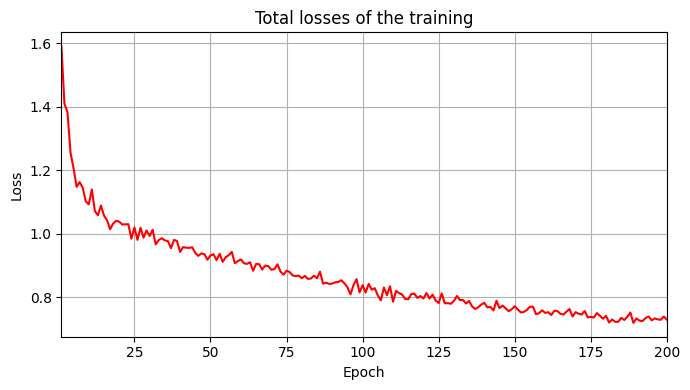

In [11]:
# Figure of the loss

plt.figure(figsize=(7,4))

# Total loss (CE + KL)
total_losses = [ce + kl_weight * kl for ce, kl in zip(ce_losses, kl_losses)]
plt.plot(epochs, total_losses, linestyle='-', color='red')

plt.xlim(1, epochs[-1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total losses of the training')
plt.grid(True)
plt.tight_layout()

In [12]:
# Computes the mean and standard deviation of predictions across samples
def compute_statistics(predictions, num_samples):

    mean = np.mean(predictions, axis=1)
    std_dev = np.std(predictions, axis=1)
    return mean, std_dev

# The inference function passes the data through the given model num_samples times to obtain distributions and make class predictions based on them
def inference(model, test_loader, num_samples=50):

    # initializations
    model.eval()
    all_means = []
    all_std_devs = []
    all_predicted_classes = []

    with torch.no_grad():
        for batch in test_loader: # Iterates through each batch of test data
            inputs = batch[0].to(torch.float32)
            batch_predictions = []

            for _ in range(num_samples): # The same batch is passed to the model num_samples times
                outputs = model(inputs) # model predictions
                probabilities = F.softmax(outputs, dim=1) # predictions as probabilities
                batch_predictions.append(probabilities.numpy()) # save the result

            # Combine predictions
            batch_predictions = np.stack(batch_predictions, axis=1)

            # Calculate means and standard deviations of predictions
            means, std_devs = compute_statistics(batch_predictions, num_samples)
            all_means.append(means)
            all_std_devs.append(std_devs)
            
            # Predicted class is the class with the highest mean
            predicted_classes = np.argmax(means, axis=1)
            all_predicted_classes.append(predicted_classes)

    # Combine results from all batches
    all_means = np.concatenate(all_means, axis=0)
    all_std_devs = np.concatenate(all_std_devs, axis=0)
    all_predicted_classes = np.concatenate(all_predicted_classes, axis=0)

    return all_means, all_std_devs, all_predicted_classes

# Format test data for inference function
test_dataset = TensorDataset(X_test_tens)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Run inference for employees and entrepreneurs to obtain predicted classes, means, and standard deviations
all_means, all_std_devs, all_predicted_classes = inference(model, test_loader, num_samples=40)


# Results

In [13]:
true_labels = y_test.to_numpy().astype(int)
predicted_labels = all_predicted_classes

# Calculate accuracy: the mean of correct predictions
accuracy = np.mean(predicted_labels == true_labels)

# Print the accuracy as a percentage
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 72.03%


In [14]:
# Classification report 
report = classification_report(true_labels, predicted_labels, output_dict=True, zero_division=0)
print(classification_report(true_labels, predicted_labels, zero_division=0))

              precision    recall  f1-score   support

           0       0.29      0.33      0.31        21
           1       0.69      0.54      0.60        54
           2       0.69      0.56      0.62        78
           3       0.49      0.69      0.57        83
           4       0.89      0.86      0.87       243

    accuracy                           0.72       479
   macro avg       0.61      0.60      0.60       479
weighted avg       0.74      0.72      0.73       479



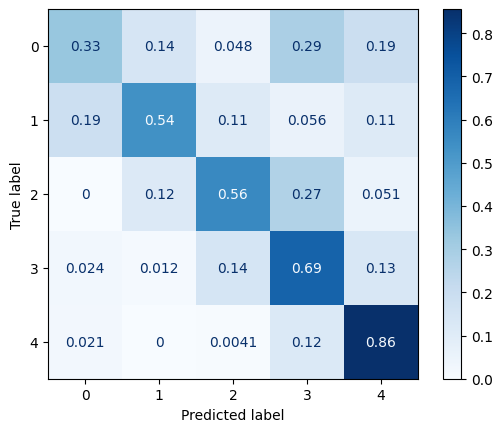

In [16]:
# Normalized confusion matrix, so we can see how the predictions are distributed between classes
confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels, normalize = 'true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3, 4])

cm_display.plot(cmap=plt.cm.Blues)
plt.show()

**Class 0**: The model correctly identifies a significant portion of Class 0 samples, but there is notable confusion with Classes 1, 3, and 4.

**Class 1**: The model performs reasonably well for Class 1, but confusion still occurs with Classes 0, 2, and 4, suggesting overlapping characteristics between these classes.

**Class 2**: Class 2 performs well but experiences confusion with Class 3, indicating some overlap in the features of these classes.

**Class 3**: Strong performance is seen for Class 3, though confusion with Class 2 remains.

**Class 4**: The highest classification accuracy is observed for Class 4, but some confusion arises with Class 3.

Overall, the confusion between classes arises because these classifications are derived from a continuous GPA scale, making them not distinctly separate categories.